In [2]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")\

Populating the interactive namespace from numpy and matplotlib


In [3]:
patient_affinitiesI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.cancer.TCGA.conservative.mut.ClassI.csv',
                               index_col=0)
patient_affinitiesII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.cancer.TCGA.conservative.mut.ClassII.csv',
                              index_col=0)

In [4]:
def patient_fractions_dataframe(MHCI_cutoff, MHCII_cutoff, patient_affinitiesI, patient_affinitiesII, high_frequency_mutations):
    fractionsI, fractionsII = [], []
    mutation_count = []
    for mutation in high_frequency_mutations:
        fractionsI.append(len(patient_affinitiesI[mutation][patient_affinitiesI[mutation] < MHCI_cutoff]) / float(len(patient_affinitiesI)))
        fractionsII.append(len(patient_affinitiesII[mutation][patient_affinitiesII[mutation] < MHCII_cutoff]) / float(len(patient_affinitiesII)))
        #mutation_count.append(patient_mutations.sum().ix[mutation])
    df = pd.DataFrame({'Mutation': high_frequency_mutations,
                       'MHCI': fractionsI,
                       'MHCII': fractionsII})
    return df

In [5]:
def plot_patient_fractions(MHCI_cutoff, MHCII_cutoff, patient_affinitiesI, patient_affinitiesII, high_frequency_mutations):
    fractionsI, fractionsII = [], []
    mutation_count = []
    for mutation in high_frequency_mutations:
        fractionsI.append(len(patient_affinitiesI[mutation][patient_affinitiesI[mutation] < MHCI_cutoff]) / float(len(patient_affinitiesI)))
        fractionsII.append(len(patient_affinitiesII[mutation][patient_affinitiesII[mutation] < MHCII_cutoff]) / float(len(patient_affinitiesII)))
        #mutation_count.append(patient_mutations.sum().ix[mutation])
    df = pd.DataFrame({'Mutation': high_frequency_mutations,
                       'MHCI': fractionsI,
                       'MHCII': fractionsII})
                       #'Mutation_count': mutation_count})
    fig, ax = plt.subplots()
    plt.axhline(0.5, color='darkred', lw=2)
    plt.axvline(0.5, color='darkred', lw=2)
    ax.scatter(df.MHCI, df.MHCII, color='grey', alpha=0.3)
    #for i, txt in enumerate(df.Mutation):
    #    ax.annotate(txt, (df.MHCI[i],df.MHCII[i]), size=8)
    plt.xlabel('Fraction of patients with MHC-I presentation')
    plt.ylabel('Fraction of patients with\nMHC-II presentation')
    plt.xlim(-0.05, max(df.MHCI))
    plt.ylim(-0.05, max(df.MHCII))
    #plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/overview/fraction_of_patients.MHCI_{0}.MHCII_{1}.pdf'.format(MHCI_cutoff,
    #                                                                                                                             MHCII_cutoff),
    #            bbox_tight=True) 
    return df

In [47]:
AF = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/mutations/mutations_with_alleleic fraction.csv',
                index_col=0)
AF = AF.groupby('combined').mean().reset_index()
AF.columns = ['Mutation', 'Mean_AF']

In [48]:
df = patient_fractions_dataframe(2, 10, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))

In [49]:
df_all = pd.merge(df, AF, on='Mutation')

In [50]:
df_all[(df_all.MHCI < 0.3)&(df_all.MHCII < 0.3)].Mean_AF.describe()

count    276.000000
mean       0.355251
std        0.134256
min        0.053376
25%        0.267251
50%        0.339397
75%        0.417532
max        0.815068
Name: Mean_AF, dtype: float64

In [51]:
df_all[(df_all.MHCI > 0.7)&(df_all.MHCII > 0.7)].Mean_AF.describe()

count    159.000000
mean       0.336621
std        0.097467
min        0.088364
25%        0.278656
50%        0.328358
75%        0.382536
max        0.707212
Name: Mean_AF, dtype: float64

In [52]:
sp.mannwhitneyu(df_all[~((df_all.MHCI < 0.5)&(df_all.MHCII < 0.5))].Mean_AF,
                df_all[(df_all.MHCI > 0.5)&(df_all.MHCII > 0.5)].Mean_AF)

MannwhitneyuResult(statistic=63413.5, pvalue=0.032688667276022793)

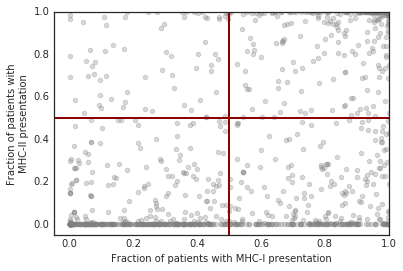

In [37]:
df = plot_patient_fractions(2, 10, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))

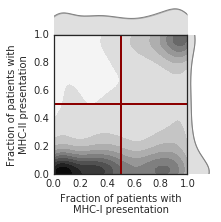

In [33]:
ax = sns.jointplot(df.MHCI, df.MHCII, color='grey', xlim=(0,1), ylim=(0,1),
             stat_func=None, kind='kde', space=0, size=3)
ax.ax_joint.axhline(0.5, color='darkred', lw=2)
ax.ax_joint.axvline(0.5, color='darkred', lw=2)
ax.ax_joint.set_xlabel('Fraction of patients with\nMHC-I presentation')
ax.ax_joint.set_ylabel('Fraction of patients with\nMHC-II presentation')
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/class_comparison/patient_presentation_fraction.pdf',
            bbox_inches='tight')

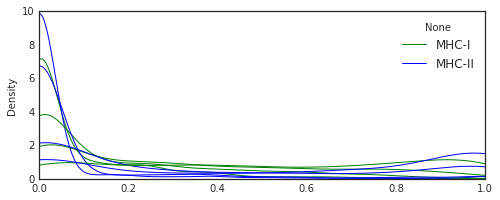

In [47]:
plt.figure(figsize=(8, 3))
for I, II in zip([0.25, 0.5, 1, 2, 4], [1, 2, 10, 20]):
    df = patient_fractions_dataframe(I, II, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))
    df.MHCI.plot.kde(xlim=(0,1), label = 'MHC-I', color='g')
    df.MHCII.plot.kde(xlim=(0,1), label = 'MHC-II', color='b')
    if I == 0.25:
        plt.legend()
#plt.show()

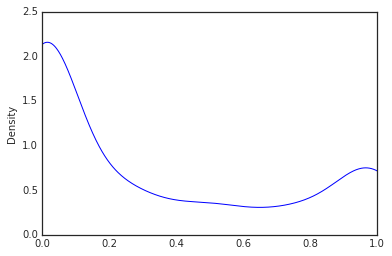

In [16]:
df.MHCII.plot.kde(xlim=(0,1))

In [10]:
df.head()

,MHCI,MHCII,Mutation
0,0.182430,0.000000,EGFR_ifd_55174772
1,0.054022,0.000000,NOTCH1_ifd_136518618
2,0.652306,0.673847,PIK3R1_ifd_68295304
3,0.491417,0.089869,CTNNB1_ifd_41224643
4,0.101649,0.000000,PIK3R1_ifd_68293795


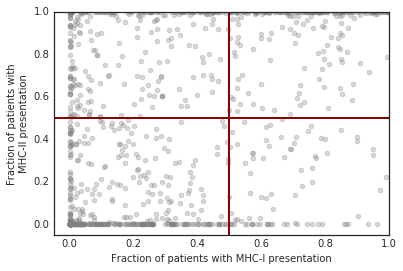

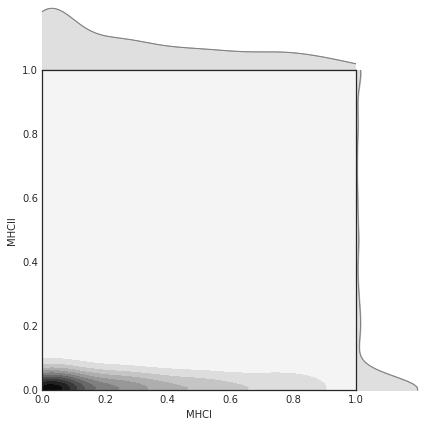

In [32]:
df_1_15 = plot_patient_fractions(1, 15, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))
sns.jointplot(df_1_5.MHCI, df_1_5.MHCII, color='grey', xlim=(0,1), ylim=(0,1),
             stat_func=None, kind='kde', space=0)

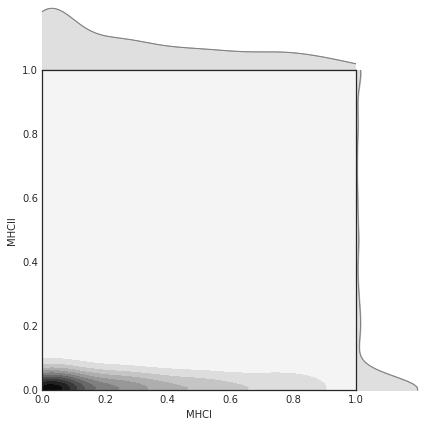

In [29]:
df_1_5 = plot_patient_fractions(1, 5, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))
sns.jointplot(df_1_5.MHCI, df_1_5.MHCII, color='grey', xlim=(0,1), ylim=(0,1),
             stat_func=None, kind='kde', space=0)

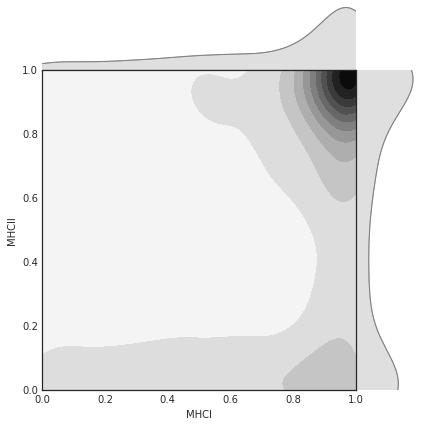

In [31]:
df_4_20 = plot_patient_fractions(4, 20, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))
sns.jointplot(df_4_20.MHCI, df_4_20.MHCII, color='grey', xlim=(0,1), ylim=(0,1),
             stat_func=None, kind='kde', space=0)

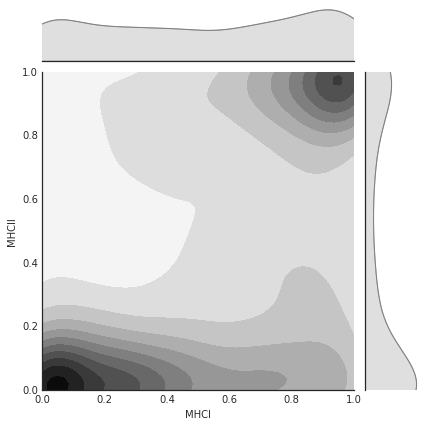

In [24]:
sns.jointplot(df_random.MHCI, df_random.MHCII, color='grey', xlim=(0,1), ylim=(0,1),
             stat_func=None, kind='kde')

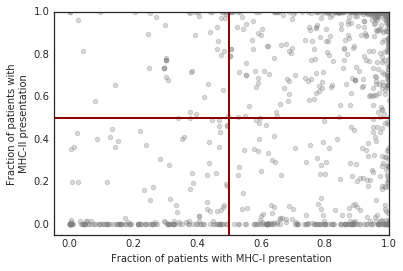

In [26]:
df_4_20 = plot_patient_fractions(4, 20, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))

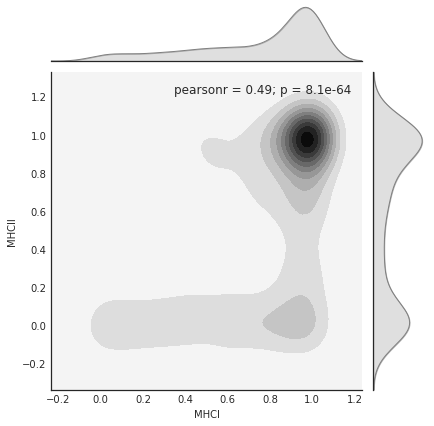

In [27]:
sns.jointplot(df_4_20.MHCI, df_4_20.MHCII, kind="kde", color='grey')

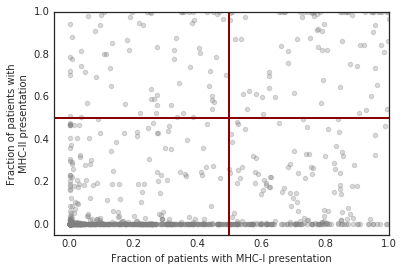

In [27]:
df_1_5 = plot_patient_fractions(1, 5, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))

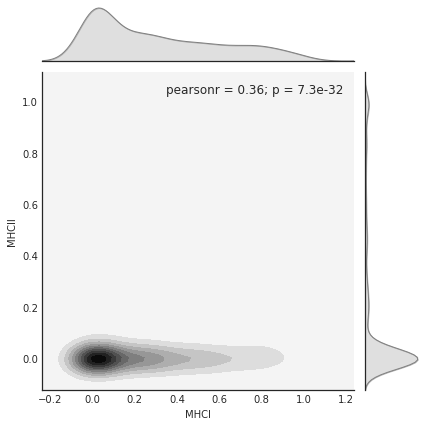

In [25]:
sns.jointplot(df_1_5.MHCI, df_1_5.MHCII, kind="kde", color='grey')

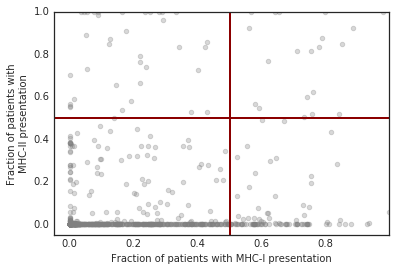

In [28]:
df_05_2 = plot_patient_fractions(0.5, 2, patient_affinitiesI, patient_affinitiesII, list(patient_affinitiesII.columns))

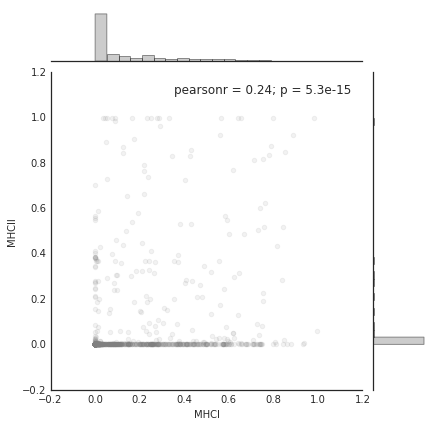

In [28]:
sns.jointplot(df_05_2.MHCI, df_05_2.MHCII, color='grey', alpha=.1)

In [14]:
df.head()

,MHCI,MHCII,Mutation
0,0.182430,0.000000,EGFR_ifd_55174772
1,0.054022,0.000000,NOTCH1_ifd_136518618
2,0.652306,0.673847,PIK3R1_ifd_68295304
3,0.491417,0.089869,CTNNB1_ifd_41224643
4,0.101649,0.000000,PIK3R1_ifd_68293795


In [29]:
print len(df[(df.MHCI < 0.5)&(df.MHCII < 0.5)]) / float(len(df))
print len(df[(df.MHCI > 0.5)&(df.MHCII > 0.5)]) / float(len(df))
print len(df[(df.MHCI < 0.5)&(df.MHCII > 0.5)]) / float(len(df))
print len(df[(df.MHCI > 0.5)&(df.MHCII < 0.5)]) / float(len(df))

0.422396856582
0.230844793713
0.0687622789784
0.277996070727


In [30]:
print len(df_random[(df_random.MHCI < 0.5)&(df_random.MHCII < 0.5)]) / float(len(df)) # bottom left
print len(df_random[(df_random.MHCI > 0.5)&(df_random.MHCII > 0.5)]) / float(len(df)) # top right
print len(df_random[(df_random.MHCI < 0.5)&(df_random.MHCII > 0.5)]) / float(len(df)) # top left
print len(df_random[(df_random.MHCI > 0.5)&(df_random.MHCII < 0.5)]) / float(len(df)) # bottom right

0.35068762279
0.25442043222
0.0726915520629
0.217092337917
